# Introduction to Transformers

**adapted from [Transformers from Scratch](https://peterbloem.nl/blog/transformers).**

# Other Explanations and Examples

* [GPT — Intuitively and Exhaustively Explained](https://towardsdatascience.com/gpt-intuitively-and-exhaustively-explained-c70c38e87491), by Daniel Warfield
* [Simplifying Transformer Blocks](https://arxiv.org/abs/2311.01906), by Bobby He and Thomas Hofmann

I am using Jax in this example.  A recent very brief summary about Jax is at [JAX: Fast as PyTorch, Simple as NumPy](https://medium.com/@hylke.donker/jax-fast-as-pytorch-simple-as-numpy-a0c14893a738).

In [1]:
import jax.numpy as jnp
import jax
import numpy 
import pandas
import matplotlib.pyplot as plt

import time
import re  # regular expressions

# jax.config.update('jax_platform_name', 'cpu')

`Fake.csv` and `True.csv` files from [Fake and real news dataset](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets) at Kaggle.

In [2]:
df_fake = pandas.read_csv('Fake.csv', usecols=['title'])
df_real = pandas.read_csv('True.csv', usecols=['title'])
df_fake.shape, df_real.shape

((23481, 1), (21417, 1))

In [3]:
pandas.set_option('max_colwidth', None)

In [4]:
df_fake.head(5)

,title
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech


In [5]:
df_real.head(5)

,title
0,"As U.S. budget fight looms, Republicans flip their fiscal script"
1,U.S. military to accept transgender recruits on Monday: Pentagon
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job'
3,FBI Russia probe helped by Australian diplomat tip-off: NYT
4,Trump wants Postal Service to charge 'much more' for Amazon shipments


In [6]:
keep = 1000
headlines_fake = df_fake.values[:keep]
labels_fake = numpy.zeros((headlines_fake.shape[0]))

headlines_real = df_real.values[:keep]
labels_real = numpy.ones((headlines_real.shape[0]))

headlines_fake.shape, labels_fake.shape, headlines_real.shape, labels_real.shape

((1000, 1), (1000,), (1000, 1), (1000,))

In [7]:
headlines_orig = headlines_fake + headlines_real

In [8]:
from string import punctuation
punctuation + ' '
print(punctuation)

def clean_up_words(titles):
    import re
    titles_words = [[word.lower() for word in re.split('\W+', title[0])] for title in titles]
    # words = [w.strip(punctuation) for w in words]
    words = [[w for w in title if len(w) > 1] for title in titles_words] 
    return words

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [9]:
re.split('\W+', headlines_fake[0][0])

['',
 'Donald',
 'Trump',
 'Sends',
 'Out',
 'Embarrassing',
 'New',
 'Year',
 's',
 'Eve',
 'Message',
 'This',
 'is',
 'Disturbing']

In [10]:
clean_up_words(headlines_fake[0:2])

[['donald',
  'trump',
  'sends',
  'out',
  'embarrassing',
  'new',
  'year',
  'eve',
  'message',
  'this',
  'is',
  'disturbing'],
 ['drunk',
  'bragging',
  'trump',
  'staffer',
  'started',
  'russian',
  'collusion',
  'investigation']]

In [11]:
headlines_fake = clean_up_words(headlines_fake)
headlines_real = clean_up_words(headlines_real)

In [12]:
headlines = headlines_fake + headlines_real
labels = numpy.hstack((labels_fake, labels_real))
len([len(h) for h in headlines]), len(labels)

(2000, 2000)

In [13]:
mx = max([len(h) for h in headlines])
mx

22

In [14]:
headlines = [headline + [' '] * (mx - len(headline)) for headline in headlines]

In [15]:
len(headlines[0]), headlines[0]

(22,
 ['donald',
  'trump',
  'sends',
  'out',
  'embarrassing',
  'new',
  'year',
  'eve',
  'message',
  'this',
  'is',
  'disturbing',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' '])

In [16]:
words = [word for headline in headlines for word in headline]
vocabulary = numpy.unique(words)
len(vocabulary)

4581

In [17]:
for i in range(100):
    print(i, vocabulary[i], end='; ')
print()
for i in range(4300, 4581):
    print(i, vocabulary[i], end='; ')

0  ; 1 000; 2 10; 3 100k; 4 11; 5 12; 6 13; 7 14; 8 15; 9 168; 10 17; 11 18; 12 19; 13 1993; 14 1st; 15 20; 16 2016; 17 2017; 18 2018; 19 2019; 20 2020; 21 20k; 22 21; 23 22; 24 25; 25 250; 26 253; 27 26; 28 27; 29 28; 30 29; 31 2nd; 32 30; 33 30k; 34 32; 35 35; 36 375; 37 401; 38 44; 39 45; 40 46; 41 49ers; 42 50; 43 500; 44 65; 45 70; 46 700; 47 74; 48 80; 49 800; 50 81; 51 95; 52 abandon; 53 abandoned; 54 abandoning; 55 abc; 56 abducted; 57 abe; 58 ability; 59 able; 60 aborted; 61 abortion; 62 about; 63 above; 64 abroad; 65 abrupt; 66 abruptly; 67 absolute; 68 absolutely; 69 abuse; 70 abuses; 71 aca; 72 accent; 73 accept; 74 access; 75 accident; 76 accidentally; 77 accomplice; 78 accomplished; 79 accomplishes; 80 according; 81 account; 82 accountability; 83 accounts; 84 accusations; 85 accuse; 86 accused; 87 accuser; 88 accusers; 89 accuses; 90 accusing; 91 acknowledge; 92 acknowledges; 93 acre; 94 across; 95 act; 96 acting; 97 action; 98 actions; 99 activists; 
4300 until; 4301 unv

In [18]:
numpy.where(numpy.array(headlines[0]).reshape(-1, 1) == vocabulary)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 array([1245, 4220, 3610, 2837, 1355, 2696, 4559, 1418, 2531, 4097, 2139,
        1214,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]))

In [19]:
numpy.where(numpy.array(headlines[0]).reshape(-1, 1) == vocabulary)[1]

array([1245, 4220, 3610, 2837, 1355, 2696, 4559, 1418, 2531, 4097, 2139,
       1214,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [20]:
tokens = [numpy.where(numpy.array(headline).reshape(-1, 1) == vocabulary)[1] for headline in headlines]
tokens[:20]

[array([1245, 4220, 3610, 2837, 1355, 2696, 4559, 1418, 2531, 4097, 2139,
        1214,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([1297,  541, 4220, 3848, 3864, 3496,  819, 2122,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([3664, 1039,  766,  406,  208, 2113, 2182, 1619, 4105, 4136, 2997,
        2930, 2034, 4081, 1478,    0,    0,    0,    0,    0,    0,    0]),
 array([4220, 2139, 3766, 2756, 1872, 1419, 1858, 2752, 2657,  805, 2117,
        1920, 4436, 2008,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([3011, 1646, 2201,  618, 2837, 1245, 4220, 1307, 1920,  745, 3804,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([3204,  168,  938,  576,  471,  535, 4464, 1872, 2139, 2034, 1828,
        1772, 2008,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([1658, 2767, 4081, 1741,  960, 4220, 2274, 2837,  309, 1522, 1127,
        1172,  214, 2157, 

In [21]:
tokens[0]

array([1245, 4220, 3610, 2837, 1355, 2696, 4559, 1418, 2531, 4097, 2139,
       1214,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [22]:
X_tokens = jnp.array(tokens)
X_tokens

2023-12-04 21:32:45.401119: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Array([[1245, 4220, 3610, ...,    0,    0,    0],
       [1297,  541, 4220, ...,    0,    0,    0],
       [3664, 1039,  766, ...,    0,    0,    0],
       ...,
       [4126, 4048, 2652, ...,    0,    0,    0],
       [1437, 4464,  126, ...,    0,    0,    0],
       [2487, 4370, 3615, ...,    0,    0,    0]], dtype=int32)

In [23]:
# Create one transformer block with the following steps.
#
#    1. Make embedding layer
#    2. Make position encoding
#    3. Make weight matrices for mapping word embedding to key, query, and value.
#    4. Make weight matrix for combining output of all heads
#    5. Define forward pass for self-attention
#    6. Make weights for dense net to apply to output of self-attention.
#    7. Define forward pass through dense net.
#    8. Make weights to linearly convert output of dense net to log probs for each class.
#    
# Finally, start classification.
#
#    9. Convert list of tokens for each review into their respective embeddings.
#    10. Pass each embedding through self-attention then dense net.
#    11. Calc mean over all outputs for a review then linearly reduce to log probs for each class.
#    12. Convert log probs to probs

In [24]:
######################################################################
# 1. Make embedding layer

n_vocabulary_words = len(vocabulary)
embed_dim = 40  
embedder_W = jnp.array(numpy.random.normal(size=(n_vocabulary_words, embed_dim)))

type(embedder_W), embedder_W.device()

(jaxlib.xla_extension.ArrayImpl, cuda(id=0))

(-0.5, 39.5, 21.5, -0.5)

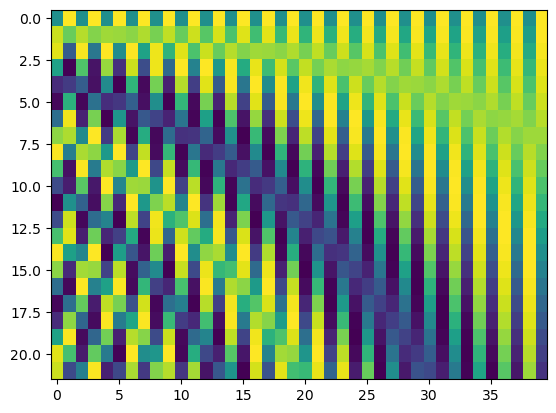

In [25]:
######################################################################
# 2. Make positional encoding (from http://jalammar.github.io/illustrated-transformer/)

def get_angles(pos, i, d_model):
   angle_rates = 1 / numpy.power(10, (2 * (i//2)) / numpy.float32(d_model))
   return pos * angle_rates

def  make_position_encoding(position, d_model):
   angle_rads = get_angles(numpy.arange(position)[:, numpy.newaxis],
                           numpy.arange(d_model)[numpy.newaxis, :],
                           d_model)
   # apply sin to even indices in the array; 2i
   angle_rads[:, 0::2] = numpy.sin(angle_rads[:, 0::2])
   # apply cos to odd indices in the array; 2i+1
   angle_rads[:, 1::2] = numpy.cos(angle_rads[:, 1::2])
   # print(angle_rads.shape)
   # pos_encoding = angle_rads[numpy.newaxis, ...]
   # print(f'{angle_rads.shape=} {pos_encoding.shape=}')
   # return jnp.array(pos_encoding) # to jax
   return jnp.array(angle_rads)

n_tokens_per_review = X_tokens.shape[1]
position_encoding = make_position_encoding(n_tokens_per_review, embed_dim)

plt.imshow(position_encoding[:, :]);
plt.axis('auto')

In [26]:
######################################################################
#  3. Make weight matrices for mapping word embedding to key, query, and value.
#  4. Make weight matrix for combining output of all heads

def make_weights(n_in, n_out):
    w_scale = 1 / jnp.sqrt(n_in)
    return jnp.array(numpy.random.uniform(-w_scale, w_scale, size=(n_in, n_out)))

n_heads = 8
n_in_per_head = embed_dim

W_keys = [make_weights(n_in_per_head, n_in_per_head) for h in range(n_heads)]
W_queries = [make_weights(n_in_per_head, n_in_per_head) for h in range(n_heads)]
W_values = [make_weights(n_in_per_head, n_in_per_head) for h in range(n_heads)]
W_combine = make_weights(n_heads * n_in_per_head, embed_dim)

print(f'W_key shapes {[w.shape for w in W_keys]}')
print(f'W_query shapes {[w.shape for w in W_queries]}')
print(f'W_value shapes {[w.shape for w in W_values]}')
print(f'W_combine shape {W_combine.shape}')

W_key shapes [(40, 40), (40, 40), (40, 40), (40, 40), (40, 40), (40, 40), (40, 40), (40, 40)]
W_query shapes [(40, 40), (40, 40), (40, 40), (40, 40), (40, 40), (40, 40), (40, 40), (40, 40)]
W_value shapes [(40, 40), (40, 40), (40, 40), (40, 40), (40, 40), (40, 40), (40, 40), (40, 40)]
W_combine shape (320, 40)


In [27]:
######################################################################
#  5. Define forward pass for self-attention

def softmax(Y, dim):
    maxY = jnp.max(Y, axis=dim, keepdims=True)
    eY = jnp.exp(Y - maxY)
    eY_sum = jnp.sum(eY, axis=dim, keepdims=True)
    return eY / eY_sum

def forward_attention(params, X):
    embedder_W, W_keys, W_queries, W_values, W_combine, _, _, _ = params

    n_samples, n_tokens, embed_dim = X.shape

    # Layer Normalization pre version, as in https://arxiv.org/pdf/2002.04745.pdf
    X = (X - X.mean(-1, keepdims=True)) / X.std(-1, keepdims=True)

    keys = [X @ W_key for W_key in W_keys]
    queries = [X @ W_query for W_query in W_queries]
    values = [X @ W_value for W_value in W_values]
    scale = jnp.sqrt(embed_dim)
    QKs = [query @ jnp.swapaxes(key, 1, 2) / scale for query, key in zip(queries, keys)]
    QKs = [softmax(QK, dim=2) for QK in QKs]

    attentions = [QK @ value for QK, value in zip(QKs, values)]
    attention = jnp.stack(attentions, axis=-1).reshape(n_samples, n_tokens, -1) @ W_combine

    return attention, QKs

In [28]:
######################################################################
#  6. Make weights for dense net to apply to output of self-attention.

n_ff_units = 10
ff_W1 = make_weights(embed_dim, n_ff_units * embed_dim)
ff_W2 = make_weights(n_ff_units * embed_dim, embed_dim)

print(f'ff_W1 shape {ff_W1.shape}')
print(f'ff_W2 shape {ff_W2.shape}')

ff_W1 shape (40, 400)
ff_W2 shape (400, 40)


In [29]:
######################################################################
#  7. Define forward pass through dense net.

def forward_transform_block(params, attention, X):

    ff_W1 = params[-2]
    ff_W2 = params[-1]
    
    X = attention + X
    # layernorm of X
    X = (X - X.mean(-1, keepdims=True)) / X.std(-1, keepdims=True)
    Y = jnp.tanh(jnp.tanh(X @ ff_W1) @ ff_W2)
    return Y

In [30]:
######################################################################
#  8. Make weights to linearly convert output of dense net to log probs for each class.

n_classes = 2
W_toprobs = make_weights(embed_dim, n_classes)
print(f'W_toprobs shape {W_toprobs.shape}')

W_toprobs shape (40, 2)


In [31]:
######################################################################
#  Finally, start classification.
#  9. Convert list of tokens for each review into their respective embeddings.

embedding = jnp.take(embedder_W, X_tokens, axis=0)  # n_reviews x max_n_tokens x embed_dim
X = embedding + position_encoding
print(f'X.shape {X.shape}')

X.shape (2000, 22, 40)


In [32]:
######################################################################
#  10. Pass each embedding through self-attention then dense net.

def forward(params, X_tokens):  # X is a  mini-batch    ,first, last):
    # Each row of X is an array of token indices, one for each word 
    embedder_W = params[0]
    X_embedding = jnp.take(embedder_W, X_tokens, axis=0)  # n_reviews x max_n_tokens x embed_dim
    X = X_embedding + position_encoding
    Y = forward_transform_block(params, forward_attention(params, X)[0], X)
    W_toprobs = params[-3]
    Y = Y @ W_toprobs
    # print(f'Output Y shape {Y.shape}')
    Y = Y.mean(axis=1)  # mean over all outputs
    return Y

params = [embedder_W, W_keys, W_queries, W_values, W_combine, W_toprobs, ff_W1, ff_W2]

forward(params, X_tokens)

Array([[-0.11391231, -0.02124749],
       [-0.12205421, -0.01937632],
       [-0.07480147, -0.04687017],
       ...,
       [-0.10195279, -0.08041643],
       [-0.08098624, -0.0529421 ],
       [-0.11963753, -0.05594535]], dtype=float32)

In [33]:
labels.reshape(-1, 1) == numpy.unique(labels)

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [34]:
def make_indicator_vars(labels):
    return jnp.array((labels.reshape(-1, 1) == numpy.unique(labels)).astype(int))

make_indicator_vars(labels)

Array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int32)

In [35]:
# Now we can implement the loss function, compute its gradient, and implement a training loop.

def loss(params, X_tokens, T):
    Y = forward(params, X_tokens)
    Y = softmax(Y, -1)
    return -jnp.mean(T * jnp.log(Y))

T = make_indicator_vars(labels)

In [36]:
loss(params, X_tokens, T)

Array(0.34396705, dtype=float32)

In [37]:
def generate_stratified_partitions(X, T, n_folds, validation=True, shuffle=True):
    '''Generates sets of  Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest
      or
       sets of Xtrain,Ttrain,Xtest,Ttest if validation is False
    Build dictionary keyed by class label. Each entry contains rowIndices and start and stop
    indices into rowIndices for each of n_folds folds'''

    def rows_in_fold(folds, k):
        all_rows = []
        for c, rows in folds.items():
            class_rows, starts, stops = rows
            all_rows += class_rows[starts[k]:stops[k]].tolist()
        return all_rows

    def rows_in_folds(folds, ks):
        all_rows = []
        for k in ks:
            all_rows += rows_in_fold(folds, k)
        return all_rows

    row_indices = numpy.arange(X.shape[0])
    if shuffle:
        numpy.random.shuffle(row_indices)
    folds = {}
    classes = numpy.unique(T)
    for c in classes:
        class_indices = row_indices[numpy.where(T[row_indices, :] == c)[0]]
        n_in_class = len(class_indices)
        n_each = int(n_in_class / n_folds)
        starts = numpy.arange(0, n_each * n_folds, n_each)
        stops = starts + n_each
        stops[-1] = n_in_class
        folds[c] = [class_indices, starts, stops]

    for test_fold in range(n_folds):
        if validation:
            for validate_fold in range(n_folds):
                if test_fold == validate_fold:
                    continue
                train_folds = numpy.setdiff1d(range(n_folds), [test_fold, validate_fold])
                rows = rows_in_fold(folds, test_fold)
                Xtest = X[rows, :]
                Ttest = T[rows, :]
                rows = rows_in_fold(folds, validate_fold)
                Xvalidate = X[rows, :]
                Tvalidate = T[rows, :]
                rows = rows_in_folds(folds, train_folds)
                Xtrain = X[rows, :]
                Ttrain = T[rows, :]
                yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest
        else:
            # No validation set
            train_folds = numpy.setdiff1d(range(n_folds), [test_fold])
            rows = rows_in_fold(folds, test_fold)
            Xtest = X[rows, :]
            Ttest = T[rows, :]
            rows = rows_in_folds(folds, train_folds)
            Xtrain = X[rows, :]
            Ttrain = T[rows, :]
            yield Xtrain, Ttrain, Xtest, Ttest

In [38]:
Xtrain, Ttrain, Xtest, Ttest = next(generate_stratified_partitions(X_tokens, T, 4, 
                                                                   validation=False, shuffle=True))
print(f'{Xtrain.shape=} {Ttrain.shape=} {Xtest.shape=} {Ttest.shape=}')

def frac_pos(T):
    return (T[:, 1] == 1).mean().item()
    
print(f'{frac_pos(Ttrain)=:.2f} {frac_pos(Ttest)=:.2f}')

Xtrain.shape=(3000, 22) Ttrain.shape=(3000, 2) Xtest.shape=(1000, 22) Ttest.shape=(1000, 2)
frac_pos(Ttrain)=0.49 frac_pos(Ttest)=0.52


In [39]:
loss_grad = jax.value_and_grad(loss)

def train(n_steps, batch_size, learning_rate):
    global params
    
    if batch_size < 0:
        batch_size = Xtrain.shape[0]
        
    print('Training started')
    losses = []
    likelihoods = []
    n_samples = Xtrain.shape[0]  # _token_indices.shape[0]

    start_time = time.time()

    for step in range(n_steps):
        likelihoods_batch = []
        first = 0
        for batch_i, first in enumerate(range(0, n_samples, batch_size)):
            Xtrain_batch = Xtrain[first:first + batch_size]
            Ttrain_batch = Ttrain[first:first + batch_size]
            loss_value, grads = loss_grad(params, Xtrain_batch, Ttrain_batch)
            losses.append(loss_value)
            likelihoods_batch.append(jnp.exp(-loss_value))
            params = [param - learning_rate * grad if not isinstance(grad, list) else
                      [par - learning_rate * gra for (par, gra) in zip(param, grad)]
                      for (param, grad) in zip(params, grads)]
        likelihoods.append(jnp.mean(jnp.array(likelihoods_batch)))  # exp(-loss_value))
        if (step + 1) % max(1, (n_steps // 20)) == 0:
            print(f'Step {step+1} Likelihood {likelihoods[-1]:.4f}')

    losses = jnp.array(losses)

    elapsed = time.time() - start_time
    print(f'Training took {elapsed/60:.1f} minutes.')

    return losses, likelihoods

Training started
Step 200 Likelihood 0.8078
Step 400 Likelihood 0.8236
Step 600 Likelihood 0.8479
Step 800 Likelihood 0.8745
Step 1000 Likelihood 0.9021
Step 1200 Likelihood 0.9210
Step 1400 Likelihood 0.9370
Step 1600 Likelihood 0.9539
Step 1800 Likelihood 0.9734
Step 2000 Likelihood 0.9868
Step 2200 Likelihood 0.9919
Step 2400 Likelihood 0.9938
Step 2600 Likelihood 0.9948
Step 2800 Likelihood 0.9954
Step 3000 Likelihood 0.9958
Step 3200 Likelihood 0.9961
Step 3400 Likelihood 0.9963
Step 3600 Likelihood 0.9965
Step 3800 Likelihood 0.9966
Step 4000 Likelihood 0.9967
Training took 8.5 minutes.


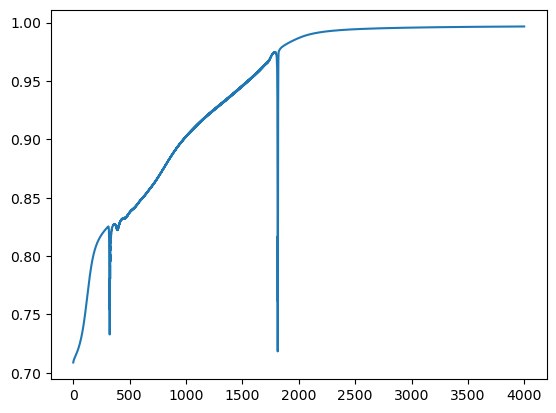

In [40]:
batch_size = -1
learning_rate = 0.1 
n_steps = 4000

losses, likelihoods = train(n_steps, batch_size, learning_rate)

plt.plot(likelihoods);

In [41]:
# To use our transformer, do a forward pass in batches, convert outputs to probabilities, then calculate a confusion matrix.

Y = []
n_samples = X_tokens.shape[0]
if batch_size > 0:
    first = 0
    for first in range(0, n_samples, batch_size):
        Y.append(forward(params, X_tokens[first:first + batch_size]))
    Y = jnp.vstack(Y)
else:
    Y = forward(params, X_tokens)

probs = softmax(Y, dim=1)
probs

Array([[9.9994373e-01, 5.6285622e-05],
       [9.9999177e-01, 8.2014903e-06],
       [9.9988592e-01, 1.1407984e-04],
       ...,
       [4.9905819e-05, 9.9995005e-01],
       [8.2219683e-02, 9.1778034e-01],
       [4.6834048e-06, 9.9999535e-01]], dtype=float32)

In [42]:
pred_classes = jnp.argmax(Y, axis=1)
actual_classes = labels # jnp.argmax(labels, axis=1)

row0 = [jnp.mean(pred_classes[actual_classes == 0] == 0),
        jnp.mean(pred_classes[actual_classes == 0] == 1)]

row1 = [jnp.mean(pred_classes[actual_classes == 1] == 0),
        jnp.mean(pred_classes[actual_classes == 1] == 1)]
cm = jnp.array([row0, row1])

pandas.DataFrame(100*cm, 
                 columns=('Pred Neg', 'Pred Pos'),
                 index=('Actual Neg', 'Actual Pos'))

,Pred Neg,Pred Pos
Actual Neg,97.100006,2.900000
Actual Pos,3.600000,96.400002


In [43]:
pandas.set_option('max_colwidth', None)

n = 10
df = pandas.DataFrame(numpy.hstack((actual_classes[:n].reshape(-1, 1),
                                    pred_classes[:n].reshape(-1, 1),
                                    headlines_orig[:n])),
                      columns=('Actual', 'Predicted', 'Headline'))
df

,Actual,Predicted,Headline
0,0.0,0,"Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is DisturbingAs U.S. budget fight looms, Republicans flip their fiscal script"
1,0.0,0,Drunk Bragging Trump Staffer Started Russian Collusion InvestigationU.S. military to accept transgender recruits on Monday: Pentagon
2,0.0,0,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’Senior U.S. Republican senator: 'Let Mr. Mueller do his job'
3,0.0,0,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)FBI Russia probe helped by Australian diplomat tip-off: NYT
4,0.0,0,Pope Francis Just Called Out Donald Trump During His Christmas SpeechTrump wants Postal Service to charge 'much more' for Amazon shipments
5,0.0,0,"Racist Alabama Cops Brutalize Black Boy While He Is In Handcuffs (GRAPHIC IMAGES)White House, Congress prepare for talks on spending, immigration"
6,0.0,0,"Fresh Off The Golf Course, Trump Lashes Out At FBI Deputy Director And James ComeyTrump says Russia probe will be fair, but timeline unclear: NYT"
7,0.0,0,"Trump Said Some INSANELY Racist Stuff Inside The Oval Office, And Witnesses Back It UpFactbox: Trump on Twitter (Dec 29) - Approval rating, Amazon"
8,0.0,0,"Former CIA Director Slams Trump Over UN Bullying, Openly Suggests He’s Acting Like A Dictator (TWEET)Trump on Twitter (Dec 28) - Global Warming"
9,0.0,0,WATCH: Brand-New Pro-Trump Ad Features So Much A** Kissing It Will Make You SickAlabama official to certify Senator-elect Jones today despite challenge: CNN


In [44]:
pandas.set_option('max_colwidth', None)

df = pandas.DataFrame(numpy.hstack((actual_classes[-n:].reshape(-1, 1),
                                    pred_classes[-n:].reshape(-1, 1),
                                    headlines_orig[-n:])),
                      columns=('Actual', 'Predicted', 'Headline'))
df

,Actual,Predicted,Headline
0,1.0,1,Spicer Quickly Orders Press Briefing To Be OFF Camera After Trump’s Indefensible Morning MeltdownWhite House says Trump will announce Fed chair pick next week
1,1.0,1,Trump Throws Hissy Fit After New York Times Reports That He Doesn’t Know What’s In His Own Healthcare BillU.S. seeks meeting soon to revive Asia-Pacific 'Quad' security forum
2,1.0,1,Republican Senator Just Had A Priest Thrown In Jail For Protesting Trumpcare (VIDEO)Trump declares opioids a U.S. public health emergency
3,1.0,1,Trump Is Fighting Disney Over ‘Hall of Presidents’ Attraction Robot SpeechU.S. belatedly begins to comply with Russia sanctions law
4,1.0,1,"Sally Yates: I Refused To Lie And Say Muslim Ban Wasn’t Based On Religion When We All Know It IsTwitter bans ads from two Russian media outlets, cites election meddling"
5,1.0,1,GOP Rep. Wants A $30k A Year Housing Allowance; Twitter RIPS Him A New OneHouse panels seek documents on Puerto Rico utility deal
6,1.0,1,"Brace Yourself For 74 Percent Higher Health Care Premiums Under New BillTrump releases some JFK files, blocks others under pressure"
7,1.0,1,Grandma Will Have To Pay More Than $20k A Year For Insurance Under GOP BillTillerson tells Myanmar army chief U.S. concerned about reported atrocities
8,1.0,1,"The Absolutely Cringeworthy Moment Trump Tried Flirting With An Irish Reporter (VIDEO)Exclusive: While advising Trump in 2016, ex-CIA chief proposed plan to discredit Turkish cleric"
9,1.0,1,A Fed Up Reporter Just Stood Up To Sarah Huckabee As She Was Smearing The Free Press (VIDEO)Mattis visits Seoul for defense talks as tensions climb


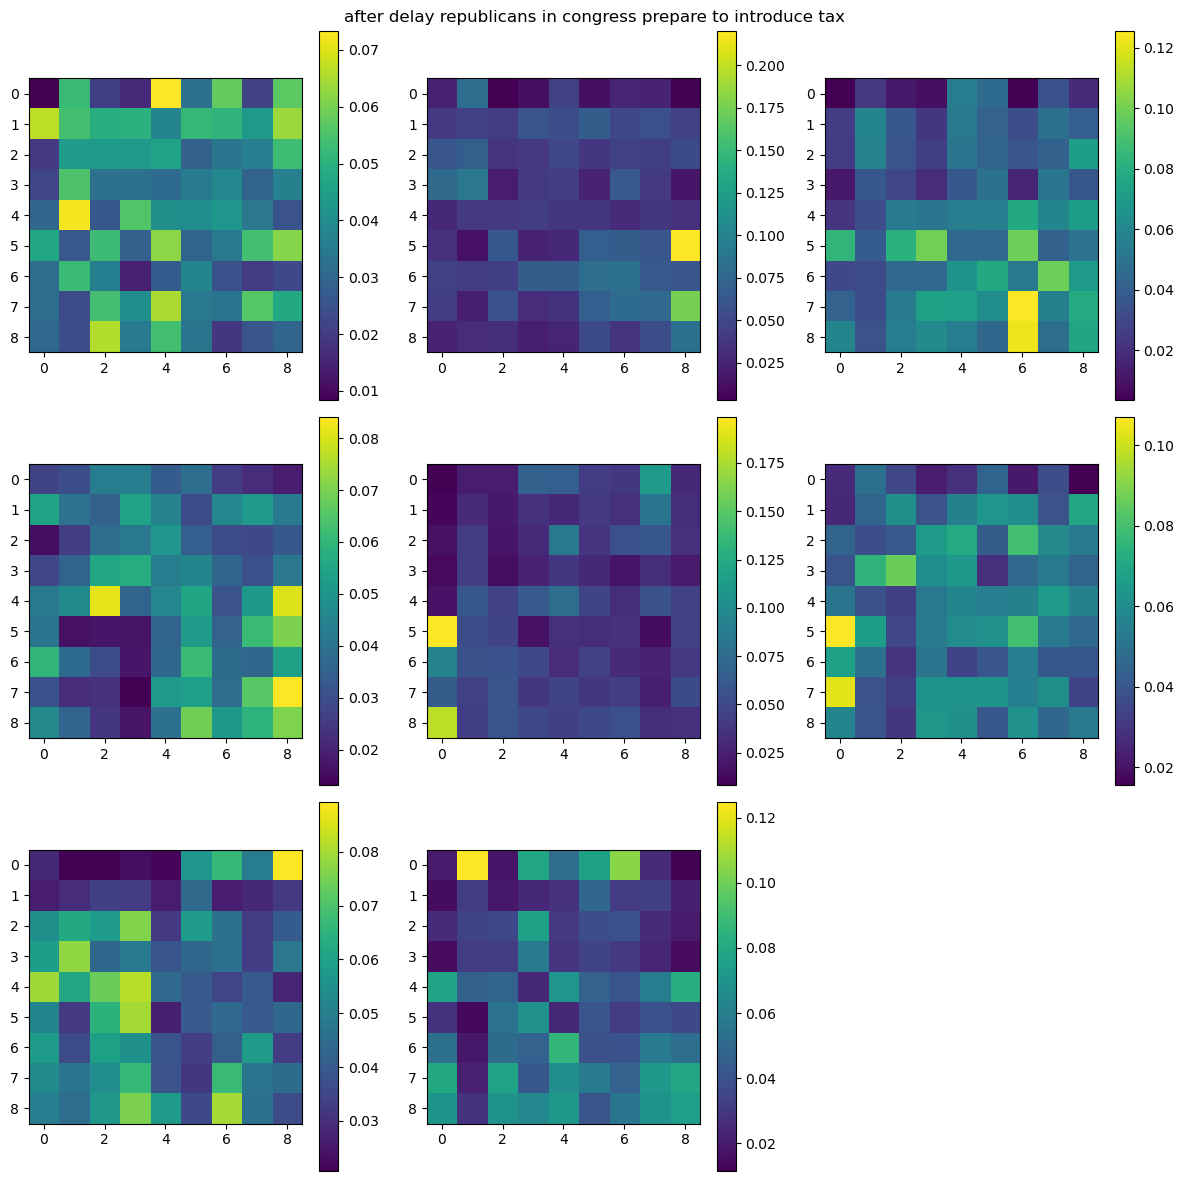

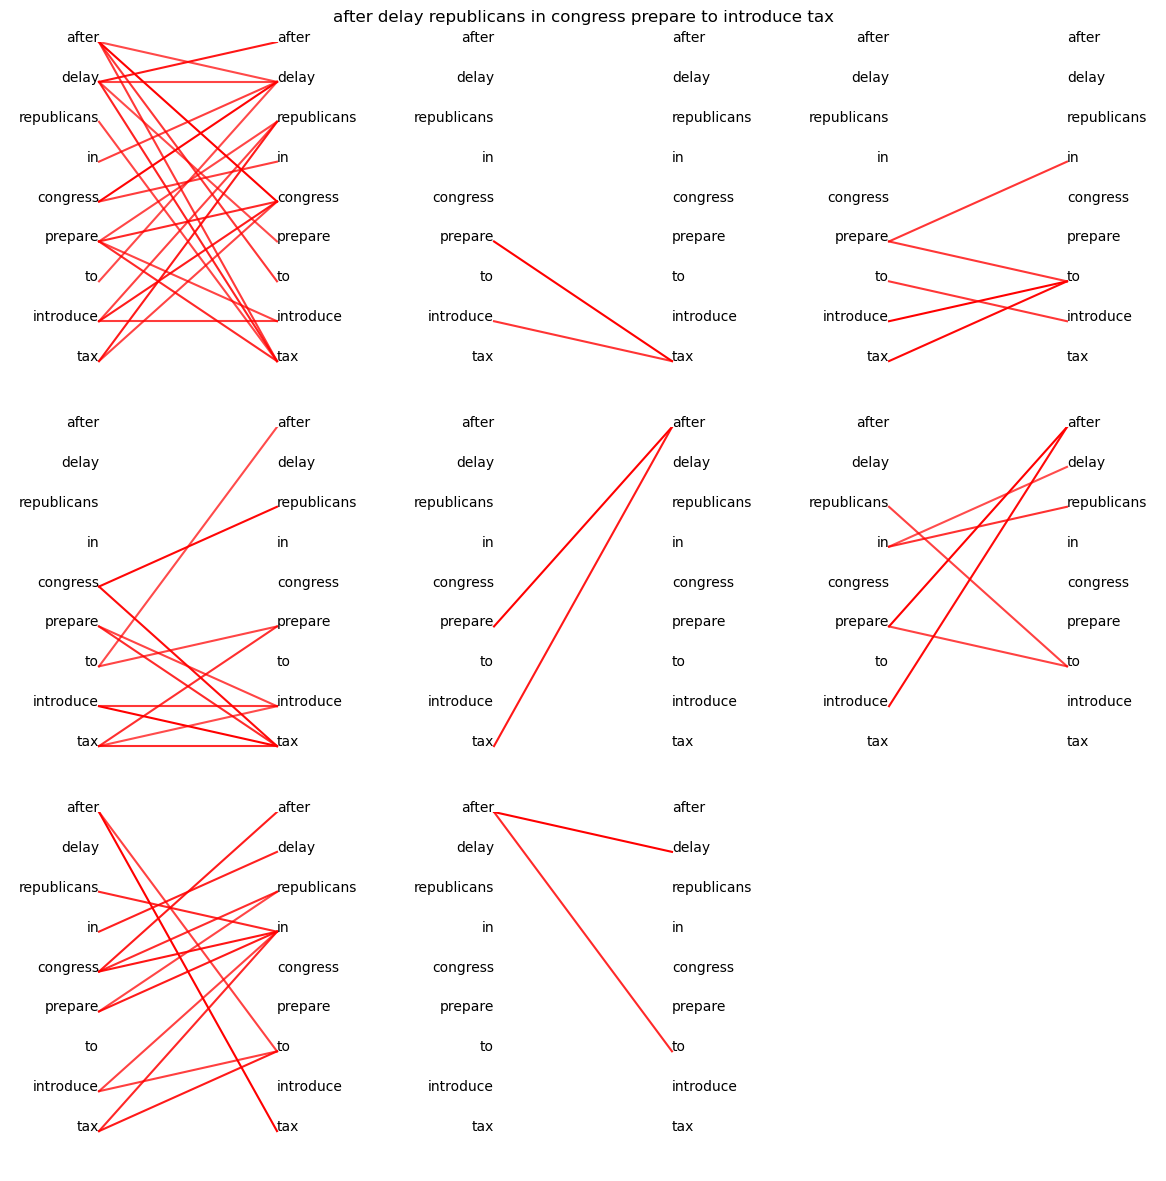

In [45]:
###### attention weights
headline_i = 1900

embedder_W = params[0]
X_embedding = jnp.take(embedder_W, X_tokens[headline_i:headline_i+1], axis=0)  # n_reviews x max_n_tokens x embed_dim
X = X_embedding + position_encoding  # [None, :, :]
attn, QKs = forward_attention(params, X)

words = headlines[headline_i]
n_words = words.index(' ') - 1
words = words[:n_words]
# n_words = len(headlines[headline_i])
plt.figure(figsize=(12, 12))
nplot = int(numpy.sqrt(n_heads)) + 1
ploti = 0
for h in range(n_heads):
    ploti += 1
    plt.subplot(nplot, nplot, ploti)
    plt.imshow(QKs[h][0, :n_words, :n_words])
    plt.colorbar()
plt.suptitle(' '.join(words))
plt.tight_layout()

## Draw attention weights as lines between words
plt.figure(figsize=(12, 12))

plt.suptitle(' '.join(words)) # headlines_orig[headline_i][0])
ploti = 0
for h in range(n_heads):
    ploti += 1
    plt.subplot(nplot, nplot, ploti)
    plt.xlim(0, 4)
    plt.ylim(0, n_words)
    plt.axis('off')
    for i, w in enumerate(words):
        plt.text(1, n_words - i, w, ha='right')
        plt.text(3, n_words - i, w, ha='left')

    QK = QKs[h][0].clone()[:n_words, :n_words]
    if True:
        mx = numpy.max(QK)
        # mn = numpy.min(QK)
        mask = QK < (0.7 * mx)
        QK = QK.at[mask].set(0.0)
        QK = QK / mx
    for i in range(n_words):
        for j in range(n_words):
            plt.plot([1, 3], [n_words - i, n_words - j], 'r', alpha=QK[i, j].item())
        
plt.tight_layout()